In [1]:
import pydicom
import glob, pylab, pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt
import os

from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

from keras.callbacks import Callback
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import pywt
import random

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/opt/conda/lib/python3.7/site-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [2]:
WINDOW_CENTER=40
WINDOW_WIDTH=80
NUM_CLASSES=1
BATCH_SIZE=128
RATIO = 10
SUBSET_NUM = int(BATCH_SIZE/RATIO)
NEGATIVE_NUM = BATCH_SIZE-SUBSET_NUM*5
STEP_SIZE_TRAIN = 40
STEP_SIZE_DEV = 1
STEP_SIZE_TEST = 1

print(SUBSET_NUM,"SUBSET_NUM")
print(NEGATIVE_NUM,"NEGATIVE_NUM")

12 SUBSET_NUM
68 NEGATIVE_NUM


In [3]:
# makes the all training .dcm file names into a list
trainingImagesDir = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/"
trainingImagesID = [f for f in listdir(trainingImagesDir) if isfile(join(trainingImagesDir, f))]
#trainingImagesID


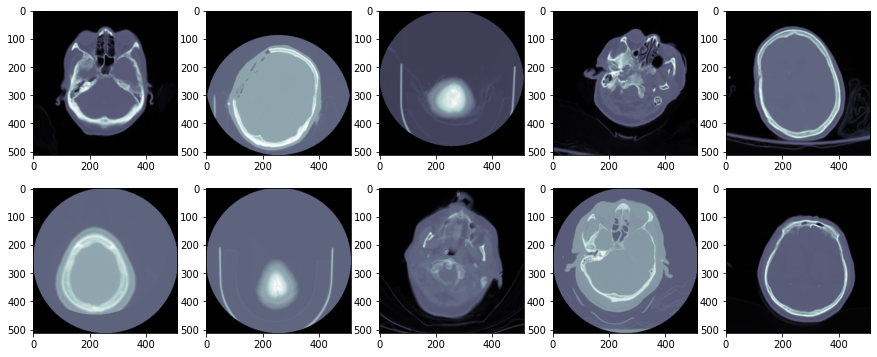

In [7]:
fig= plt.figure(figsize = (15,6))
columns =5 ; rows = 2
for i in range (1, columns*rows+1):
    dataSet = pydicom.dcmread(trainingImagesDir +trainingImagesID[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(dataSet.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

In [14]:
print("Total labeled data #:",len(trainingImagesID))

Total labeled data #: 752803


In [12]:
import pandas as pd #IMPORT PANDA USEFUL FOR LARGE DATA PROCESSING
TrainingDataLabel = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv")
print(TrainingDataLabel)
# Divide the ID and subtype so that we can read in images (images are in ID.dcm format)

label = TrainingDataLabel.Label.values # get label column as label
TrainingDataLabel = TrainingDataLabel.ID.str.rsplit("_",n=1, expand=True) # split the after the ID (n=1)because the image files are named so
TrainingDataLabel.loc[:,"label"] = label # add label column and add label(data)
TrainingDataLabel = TrainingDataLabel.rename({0 :"ID", 1: "Subtype"}, axis=1)

# Vectorize the data
TrainingDataLabel = pd.pivot_table(TrainingDataLabel, index="ID", columns="Subtype", values="label") # make a table with row (id) column (subtype) and label values inside


# export the data in csv form 
TrainingDataLabel.to_csv("processed_stage_1_train.csv")

# check the output is correct
check = pd.read_csv("processed_stage_1_train.csv")
check
# check it looks the same as the chart above



                                    ID  Label
0                ID_12cadc6af_epidural      0
1        ID_12cadc6af_intraparenchymal      0
2        ID_12cadc6af_intraventricular      0
3            ID_12cadc6af_subarachnoid      0
4                ID_12cadc6af_subdural      0
...                                ...    ...
4516837  ID_4a85a3a3f_intraparenchymal      0
4516838  ID_4a85a3a3f_intraventricular      0
4516839      ID_4a85a3a3f_subarachnoid      0
4516840          ID_4a85a3a3f_subdural      0
4516841               ID_4a85a3a3f_any      0

[4516842 rows x 2 columns]


,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...,...
752798,ID_ffff82e46,0,0,0,0,0,0
752799,ID_ffff922b9,1,0,0,1,0,0
752800,ID_ffffb670a,1,0,0,0,1,0
752801,ID_ffffcbff8,0,0,0,0,0,0


In [7]:
train_d=check


In [8]:
def create_dataset(df, step_size, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES, n=SUBSET_NUM,m=NEGATIVE_NUM):     
    epidural_df =df[df["epidural"]==1]
    intraparenchymal_df = df[df["intraparenchymal"]==1]
    intraventricular_df = df[df["intraventricular"]==1]
    subarachnoid_df = df[df["subarachnoid"]==1]
    subdural_df = df[df["subdural"]==1]
    any_df = df[df["any"]==1]
    neg_df = df[df["any"]==0]
    
    print("# of epidural", len(epidural_df))
    print("# of intraparenchymal", len(intraparenchymal_df))
    print("# of intraventricular", len(intraventricular_df))
    print("# of subarachnoid", len(subarachnoid_df))
    print("# of subdural ", len(subdural_df))
    print("# of any", len(any_df))
    print("# of neg", len(neg_df))
    print("df size: ", len(df))
    print(" ")
    
    epidural_np = epidural_df.to_numpy()
    intraparenchymal_np = intraparenchymal_df.to_numpy()
    intraventricular_np = intraventricular_df.to_numpy() 
    subarachnoid_np = subarachnoid_df.to_numpy()
    subdural_np = subdural_df.to_numpy()
    any_np = any_df.to_numpy()
    neg_np = neg_df.to_numpy()

    balanced_label = np.zeros((step_size, batch_size, num_classes), dtype=np.float32)
    balanced_id= np.zeros((step_size, batch_size), dtype="U16") #ID_000039fa0.dcm
    for i in range(step_size):
        for j in range (n):
            balanced_label[i][j] = epidural_np[i*n+j][1:7]
            balanced_label[i][j+n] = intraparenchymal_np[i*n+j][1:7]
            balanced_label[i][j+2*n] = intraventricular_np[i*n+j][1:7]
            balanced_label[i][j+3*n] = subarachnoid_np[i*n+j][1:7]
            balanced_label[i][j+4*n] = subdural_np[i*n+j][1:7]

            balanced_id[i][j] = epidural_np[i*n+j][0]
            balanced_id[i][j+n] = intraparenchymal_np[i*n+j][0]
            balanced_id[i][j+2*n] = intraventricular_np[i*n+j][0]
            balanced_id[i][j+3*n] = subarachnoid_np[i*n+j][0]
            balanced_id[i][j+4*n] = subdural_np[i*n+j][0]

        for j in range (m):
            balanced_label[i][j+5*n] = neg_np[i*n+j][1:7]
            balanced_id[i][j+5*n] = neg_np[i*n+j][0]
            
    return balanced_id, balanced_label
 

In [9]:
def create_dataset_intraparenchymal(df, step_size, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES, n=64,m=64):     
    intraparenchymal_df =df[(df["epidural"]==0) & (df["intraparenchymal"]==1) & (df["intraventricular"]==0) & (df["subarachnoid"]==0) & (df["subdural"]==0)]

    neg_df = df[df["any"]==0]
    
    print("# of intraparenchymal", len(intraparenchymal_df))

    print("# of neg", len(neg_df))
    print("df size: ", len(df))
    print(" ")
    
    intraparenchymal_np = intraparenchymal_df.to_numpy()

    neg_np = neg_df.to_numpy()

    balanced_label = np.zeros((step_size, batch_size), dtype=np.float32)
    balanced_id= np.zeros((step_size, batch_size), dtype="U16") #ID_000039fa0.dcm
    for i in range(step_size):
        for j in range (64):
            balanced_label[i][j] = intraparenchymal_np[i+j][3]

            balanced_id[i][j] = intraparenchymal_np[i+j][0]


        for j in range (64):
            balanced_label[i][64+j] = neg_np[i+j][3]
            balanced_id[i][64+j] = neg_np[i+j][0]
            
    return balanced_id, balanced_label

In [10]:
def create_dataset_epi(df, step_size, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES, n=64,m=64):     
    subd_df =df[(df["epidural"]==1) & (df["intraparenchymal"]==0) & (df["intraventricular"]==0) & (df["subarachnoid"]==0) & (df["subdural"]==0)]
    neg_df = df[df["any"]==0]
    
    print("# of subdural ", len(subd_df))

    print("# of neg", len(neg_df))
    print("df size: ", len(df))
    print(" ")
    
    subd_np = subd_df.to_numpy()

    neg_np = neg_df.to_numpy()

    balanced_label = np.zeros((step_size, batch_size), dtype=np.float32)
    balanced_id= np.zeros((step_size, batch_size), dtype="U16") #ID_000039fa0.dcm
    for i in range(step_size):
        for j in range (64):
            balanced_label[i][j] = subd_np[i+j][2]

            balanced_id[i][j] = subd_np[i+j][0]


        for j in range (64):
            balanced_label[i][64+j] = neg_np[i+j][2]
            balanced_id[i][64+j] = neg_np[i+j][0]
            
    return balanced_id, balanced_label

In [11]:
def create_dataset_any(df, step_size, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES, n=64,m=64):     
    #intraparenchymal_df =df[(df["epidural"]==0) & (df["intraparenchymal"]==1) & (df["intraventricular"]==0) & (df["subarachnoid"]==0) & (df["subdural"]==0)]
    any_df=df[df["any"]==1]
    neg_df = df[df["any"]==0]
    
    print("# of true", len(any_df))

    print("# of neg", len(neg_df))
    print("df size: ", len(df))
    print(" ")
    
    any_np = any_df.to_numpy()

    neg_np = neg_df.to_numpy()

    balanced_label = np.zeros((step_size, batch_size), dtype=np.float32)
    balanced_id= np.zeros((step_size, batch_size), dtype="U16") #ID_000039fa0.dcm
    for i in range(step_size):
        for j in range (64):
            balanced_label[i][j] = any_np[i+j][1]

            balanced_id[i][j] = any_np[i+j][0]


        for j in range (64):
            balanced_label[i][64+j] = neg_np[i+j][1]
            balanced_id[i][64+j] = neg_np[i+j][0]
            
    return balanced_id, balanced_label

In [12]:
import tensorflow.compat.v1 as tf 

In [13]:
#random.seed(1)
print(len(train_d))
train_np=train_d.to_numpy() 
random.shuffle(train_np) #shuffles the rows
m = len(train_np[:,0])
print("m: ",m)

# split the dataset into train/dev/test (60/20/20)
split1 = int(0.6 * m)
split2 = int(0.8 * m)
train_df = train_np[:split1]
dev_df = train_np[split1: split2]
test_df = train_np[split2: ]

# change the numpy list into a dataframe
train_df = pd.DataFrame(train_df)
dev_df = pd.DataFrame(dev_df)
test_df = pd.DataFrame(test_df)
#print(train_df)

# rename the columns so that we can easily visualize the data
train_df=train_df.rename({0:"ID", 1: "any", 2:"epidural", 3:"intraparenchymal", 4:"intraventricular", 5:"subarachnoid", 6:"subdural"}, axis=1)
dev_df=dev_df.rename({0:"ID", 1: "any", 2:"epidural", 3:"intraparenchymal", 4:"intraventricular", 5:"subarachnoid", 6:"subdural"}, axis=1)
test_df=test_df.rename({0:"ID", 1: "any", 2:"epidural", 3:"intraparenchymal", 4:"intraventricular", 5:"subarachnoid", 6:"subdural"}, axis=1)
train_id, train_label = create_dataset_epi(df = train_df, step_size = STEP_SIZE_TRAIN)#, any_df, epidural_df, intraparenchymal_df, intraventricualr_df, subarachnoid_df, subdural_df

dev_id, dev_label = create_dataset_epi(df = dev_df, step_size = STEP_SIZE_DEV) 
print(dev_label)
test_id, test_label = create_dataset_epi(df = test_df, step_size = STEP_SIZE_TEST)

752803
m:  752803
# of subdural  1008
# of neg 386650
df size:  451681
 
# of subdural  342
# of neg 128885
df size:  150561
 
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
# of subdural  358
# of neg 128982
df size:  150561
 


In [14]:
def pixel2HU(dcm_image):
    pixel_image = dcm_image.pixel_array
    HU_image = pixel_image * dcm_image.RescaleSlope + dcm_image.RescaleIntercept
    
    w=HU_image.shape[0]
    h=HU_image.shape[1]
    n=448
    resized_image = np.zeros((n,n),dtype=np.float32)
    p = w-n
    p2 = int(p/2) #32
    q = h-n
    q2 = int(q/2)
    
    if p >= 0 and q >= 0:
        resized_image=HU_image[p2 : p2 + n, q2: q2 + n]
    elif p >= 0 and q < 0: 
        resized_image[:,0:h]=HU_image[p2 : p2 + n, 0: h]
    elif p < 0 and q >= 0: 
        resized_image[0:w,:]=HU_image[0 : w , q2: q2+n]
    else: # p < 0 q < 0 
        resized_image[0:w, 0:h]=HU_image[0:w, 0:h]
    
    return resized_image 

In [15]:
def pixel2HULL(dcm_image):
    pixel_image = dcm_image.pixel_array
    HU_image = pixel_image * dcm_image.RescaleSlope + dcm_image.RescaleIntercept
    coeffs1 = pywt.dwt2(HU_image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs1
    w=LL.shape[0]
    h=LL.shape[1]
    n=448
    resized_image = np.zeros((n,n),dtype=np.float64)
    p = w-n
    p2 = int(p/2) #32
    q = h-n
    q2 = int(q/2)
    
    if p >= 0 and q >= 0:
        resized_image=LL[p2 : p2 + n, q2: q2 + n]
    elif p >= 0 and q < 0: 
        resized_image[:,0:h]=LL[p2 : p2 + n, 0: h]
    elif p < 0 and q >= 0: 
        resized_image[0:w,:]=LL[0 : w , q2: q2+n]
    else: # p < 0 q < 0 
        resized_image[0:w, 0:h]=LL[0:w, 0:h]
    
    return resized_image 

In [16]:
def pixel2HUDE(dcm_image):
    pixel_image = dcm_image.pixel_array
    HU_image = pixel_image * dcm_image.RescaleSlope + dcm_image.RescaleIntercept
    coeffs1 = pywt.dwt2(HU_image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs1
    DE=(LH+HL+HH)
    w=DE.shape[0]
    h=DE.shape[1]
    n=448
    resized_image = np.zeros((n,n),dtype=np.float64)
    p = w-n
    p2 = int(p/2) #32
    q = h-n
    q2 = int(q/2)
    
    if p >= 0 and q >= 0:
        resized_image=DE[p2 : p2 + n, q2: q2 + n]
    elif p >= 0 and q < 0: 
        resized_image[:,0:h]=DE[p2 : p2 + n, 0: h]
    elif p < 0 and q >= 0: 
        resized_image[0:w,:]=DE[0 : w , q2: q2+n]
    else: # p < 0 q < 0 
        resized_image[0:w, 0:h]=DE[0:w, 0:h]
    
    return resized_image 

In [17]:
def pixel2HUALL(dcm_image):
    pixel_image = dcm_image.pixel_array
    HU_image = pixel_image * dcm_image.RescaleSlope + dcm_image.RescaleIntercept
    coeffs1 = pywt.dwt2(HU_image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs1
    ALL=(LL+LH+HL+HH)
    w=ALL.shape[0]
    h=ALL.shape[1]
    n=448
    resized_image = np.zeros((n,n),dtype=np.float64)
    p = w-n
    p2 = int(p/2) #32
    q = h-n
    q2 = int(q/2)
    
    if p >= 0 and q >= 0:
        resized_image=ALL[p2 : p2 + n, q2: q2 + n]
    elif p >= 0 and q < 0: 
        resized_image[:,0:h]=ALL[p2 : p2 + n, 0: h]
    elif p < 0 and q >= 0: 
        resized_image[0:w,:]=ALL[0 : w , q2: q2+n]
    else: # p < 0 q < 0 
        resized_image[0:w, 0:h]=ALL[0:w, 0:h]
    
    return resized_image 

In [18]:
def set_sigmoid_window(HU_image, window_center=50, window_width=130, ymin=0, ymax=1):
    x = HU_image
    y = np.zeros_like(x)  
    
    U=255 #upper limit of windowing functions
    epsilon =1. # margin between upper/lower limit
    alpha=np.log(U/epsilon-1.)
    W= np.float64(2./window_width)*alpha
    b= np.float64((-2.*window_center)/window_width)*alpha
    y = np.float64(U/(1+np.exp(-(W*x+b))))

    return y

In [19]:
def set_window(LL, window_center=50, window_width=130, ymin=0, ymax=1):
    x = LL
    c = window_center
    w = window_width    
    y = np.zeros_like(x)
    
    y[x <= (c - 0.5 - (w - 1) / 2)] = ymax
    y[x > (c - 0.5 + (w - 1) / 2)] = ymin # by making this ymax it will show up as white if non of the above
    y[(x > (c - 0.5 - (w - 1) / 2)) & (x <= (c - 0.5 + (w - 1) / 2))] = \
    ((x[(x > (c - 0.5 - (w - 1) / 2)) & (x <= (c - 0.5 + (w - 1) / 2))] - (c - 0.5)) / (w - 1) + 0.5) * (ymax - ymin) + ymin
    
    return y   

In [20]:
def generate_training_batch(num_classes=NUM_CLASSES, step_size=STEP_SIZE_TRAIN,path=trainingImagesDir, batch_size=BATCH_SIZE, myLabel = train_label, myID = train_id,  window_center=WINDOW_CENTER, window_width=WINDOW_WIDTH): 
    batch_index = 0
    batch_X = np.zeros((batch_size, 448, 448, 3),dtype=np.float64)
    batch_Y = np.zeros((batch_size, num_classes),dtype=np.float64)
    while True:
        #print("ID", batch_index)
        Label = myLabel[batch_index]
        ID = myID[batch_index]
        #print("iteration num", iteration)
        for index in range(batch_size):            
            pixel_image_temp = pydicom.dcmread(path+ID[index]+".dcm")
            HU_image_temp = pixel2HUALL(pixel_image_temp)
            batch_X[index,:,:,0]=set_sigmoid_window(HU_image_temp, 600, 2000) #Bone
            batch_X[index,:,:,1]=set_sigmoid_window(HU_image_temp, 40, 80) #Brain
            batch_X[index,:,:,2]=set_sigmoid_window(HU_image_temp, 50, 130) #Blood          
            batch_Y[index] = Label[index]      
        
        yield batch_X, batch_Y
        batch_index=batch_index+1
        if batch_index >= step_size  :
            batch_index=0   

In [21]:
def generate_validation_batch(num_classes=NUM_CLASSES, step_size=STEP_SIZE_DEV,path=trainingImagesDir, batch_size=BATCH_SIZE, myLabel = dev_label, myID = dev_id,  window_center=WINDOW_CENTER, window_width=WINDOW_WIDTH):
    
    batch_index = 0
    batch_X = np.zeros((batch_size, 448, 448, 3),dtype=np.float64)
    batch_Y = np.zeros((batch_size, num_classes),dtype=np.float64)
    while True:
       # print("ID", batch_index)
        Label = myLabel[batch_index]
        ID = myID[batch_index]
        #print("iteration num", iteration)
        for index in range(batch_size):            
            pixel_image_temp = pydicom.dcmread(path+ID[index]+".dcm")
            HU_image_temp = pixel2HUALL(pixel_image_temp)
            
            batch_X[index,:,:,0]=set_sigmoid_window(HU_image_temp, 600, 2800) #Bone
            batch_X[index,:,:,1]=set_sigmoid_window(HU_image_temp, 40, 80) #Brain
            batch_X[index,:,:,2]=set_sigmoid_window(HU_image_temp, 50, 130) #Blood       
            
            batch_Y[index] = Label[index]      
        
        yield batch_X, batch_Y
        batch_index=batch_index+1
        if batch_index >=  step_size  :
            batch_index=0

In [22]:
def test_batch_X(path=trainingImagesDir,batch_size=BATCH_SIZE, myLabel= test_label, myID=test_id):
    batch_index = 1
    batch_X = np.zeros((batch_size, 448, 448, 3),dtype=np.float64)
    ID = myID[0]
         
    pixel_image_temp = pydicom.dcmread(path+ID[batch_index]+".dcm")
    HU_image_temp = pixel2HUALL(pixel_image_temp)           
    batch_X[batch_index,:,:,0]=set_sigmoid_window(HU_image_temp, 600, 2800) #Bone
    batch_X[batch_index,:,:,1]=set_sigmoid_window(HU_image_temp, 40, 80) #Brain
    batch_X[batch_index,:,:,2]=set_sigmoid_window(HU_image_temp, 50, 130) #Blood      
    
    return batch_X
#test_batch_X()
#print(ID)
        
def test_batch_Y(num_classes=NUM_CLASSES, batch_size=BATCH_SIZE, myLabel= test_label, myID=test_id):
    batch_Y = np.zeros((batch_size, num_classes),dtype=int)
    batch_index = 0
    batch_Y = myLabel[batch_index]
    
    return batch_Y

def test_batch_ID(path=trainingImagesDir,batch_size=BATCH_SIZE, myLabel= test_label, myID=test_id):
    batch_ID = np.zeros((batch_size, 1))
    batch_index = 0
    batch_ID = myID[batch_index]
    return batch_ID
#test_batch_ID()
    

In [23]:
def ResNet50_altered(image_h=512, image_w=512, image_c=3, num_classes=NUM_CLASSES):
    # get input image size (448, 448, 3)
    X_input = Input(shape=(image_h, image_w, image_c))
    # get it down to (224, 224, 3) by Max-Pooling
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(X_input)
    # get pre-trained model with last layer turned off   
    X2 = ResNet50(input_tensor = X, weights = 'imagenet', include_top = False)
    # freeze pre-trained weights
    
    for layer in X2.layers: 
        layer.trainable = False
    
    X3 = X2.output
    X3 = GlobalAveragePooling2D()(X3)
    X3 = Dense(1024, activation = 'relu')(X3)
    predictions = Dense(num_classes, activation = "sigmoid", kernel_initializer = glorot_uniform())(X3)

    # final training model
    model = Model(inputs=X_input, outputs=predictions)

    return model 

In [24]:
def VGG16_altered(image_h=512, image_w=512, image_c=3, num_classes=NUM_CLASSES):
    X_input = Input(shape=(image_h, image_w, image_c))
    # get it down to (224, 224, 3) by Max-Pooling
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(X_input)
    # get pre-trained model with last layer turned off   
    X2 = vgg16 = VGG16(input_tensor = X + [3], weights='imagenet', include_top=False)
    # freeze pre-trained weights
    
    for layer in vgg16.layers:
     layer.trainable = False
    
    X3 = X2.output
    X3 = GlobalAveragePooling2D()(X3)
    X3 = Dense(1024, activation = 'relu')(X3)
    predictions = Dense(num_classes, activation = "sigmoid", kernel_initializer = glorot_uniform())(X3)

    # final training model
    model = Model(inputs=X_input, outputs=predictions)

    return model 



In [25]:
def VGG19_altered(image_h=512, image_w=512, image_c=3, num_classes=NUM_CLASSES):
    X_input = Input(shape=(image_h, image_w, image_c))
    # get it down to (224, 224, 3) by Max-Pooling
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(X_input)
    # get pre-trained model with last layer turned off   
    X2= vgg19 = VGG19(input_tensor = X + [3], weights='imagenet', include_top=False)
    # freeze pre-trained weights
    
    for layer in vgg19.layers:
     layer.trainable = False
    
    X3 = X2.output
    X3 = GlobalAveragePooling2D()(X3)
    X3 = Dense(1024, activation = 'relu')(X3)
    predictions = Dense(num_classes, activation = "sigmoid", kernel_initializer = glorot_uniform())(X3)

    # final training model
    model = Model(inputs=X_input, outputs=predictions)

    return model 


In [26]:
def dens_altered(image_h=512, image_w=512, image_c=3, num_classes=NUM_CLASSES):
    X_input = Input(shape=(image_h, image_w, image_c))
    # get it down to (224, 224, 3) by Max-Pooling
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(X_input)
    # get pre-trained model with last layer turned off   
    X2= vgg19 = DenseNet121(input_tensor = X + [3], weights='imagenet', include_top=False)
    # freeze pre-trained weights
    
    for layer in vgg19.layers:
     layer.trainable = False
    
    X3 = X2.output
    X3 = GlobalAveragePooling2D()(X3)
    X3 = Dense(1024, activation = 'relu')(X3)
    predictions = Dense(num_classes, activation = "sigmoid", kernel_initializer = glorot_uniform())(X3)

    # final training model
    model = Model(inputs=X_input, outputs=predictions)

    return model 

In [27]:
def Xception_altered(image_h=512, image_w=512, image_c=3, num_classes=NUM_CLASSES):
    X_input = Input(shape=(image_h, image_w, image_c))
    # get it down to (224, 224, 3) by Max-Pooling
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(X_input)
    # get pre-trained model with last layer turned off   
    X2= vgg19 = Xception(input_tensor = X + [3], weights='imagenet', include_top=False)
    # freeze pre-trained weights
    
    for layer in vgg19.layers:
     layer.trainable = False
    
    X3 = X2.output
    X3 = GlobalAveragePooling2D()(X3)
    X3 = Dense(1024, activation = 'relu')(X3)
    predictions = Dense(num_classes, activation = "sigmoid", kernel_initializer = glorot_uniform())(X3)

    # final training model
    model = Model(inputs=X_input, outputs=predictions)

    return model 

In [28]:
def compile_model(model):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())

In [29]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import tensorflow as tf
print(tf.__version__)

2022-12-07 14:06:34.103066: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 14:06:34.167965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 14:06:34.278368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 14:06:34.279305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

2.6.4


2022-12-07 14:06:36.453656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 14:06:36.454915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 14:06:36.455847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 14:06:36.456625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8140 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [30]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [31]:
model = Xception_altered(image_h=448, image_w=448, image_c=3, num_classes=NUM_CLASSES)
compile_model(model)

train_generator=generate_training_batch()
print(train_generator)
dev_generator=generate_validation_batch()

NUM_EPOCHS =10
model_history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=NUM_EPOCHS, validation_data=dev_generator, validation_steps=STEP_SIZE_DEV, validation_freq=1)
#model_history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=NUM_EPOCHS, validation_data=dev_generator, validation_steps=STEP_SIZE_DEV, validation_freq=1)
#history=model.fit_generator(train_generator, steps_per_epoch=8, epochs=13)

#save model
model.save("TRIAL5_model_ResNet50_MULTI_RGB_SIGMOID_image224_epoch10_stepSize10.h5")

2022-12-07 14:06:36.783213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 14:06:36.784216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 14:06:36.784876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 14:06:36.785767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 14:06:36.786438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 224, 224, 3)  0           max_pooling2d[0][0]              
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         tf.__operators__.add[0][0]       
_____________________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
2022-12-07 14:06:41.999362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-07 14:06:45.762283: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


40/40 [==============================] - 103s 2s/step - loss: 0.2113 - accuracy: 0.9439 - val_loss: 2.7850 - val_accuracy: 0.6016
Epoch 2/10
40/40 [==============================] - 93s 2s/step - loss: 0.0054 - accuracy: 0.9992 - val_loss: 2.8980 - val_accuracy: 0.6406
Epoch 3/10
40/40 [==============================] - 92s 2s/step - loss: 7.7231e-04 - accuracy: 1.0000 - val_loss: 2.9646 - val_accuracy: 0.6484
Epoch 4/10
40/40 [==============================] - 93s 2s/step - loss: 4.3400e-04 - accuracy: 1.0000 - val_loss: 3.0008 - val_accuracy: 0.6172
Epoch 5/10
40/40 [==============================] - 93s 2s/step - loss: 3.3772e-04 - accuracy: 1.0000 - val_loss: 3.0351 - val_accuracy: 0.6172
Epoch 6/10
40/40 [==============================] - 93s 2s/step - loss: 2.7028e-04 - accuracy: 1.0000 - val_loss: 3.0679 - val_accuracy: 0.6094
Epoch 7/10
40/40 [==============================] - 93s 2s/step - loss: 2.2056e-04 - accuracy: 1.0000 - val_loss: 3.0998 - val_accuracy: 0.6094
Epoch 8/10

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


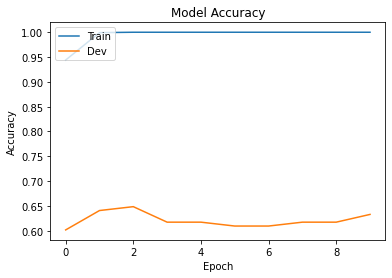

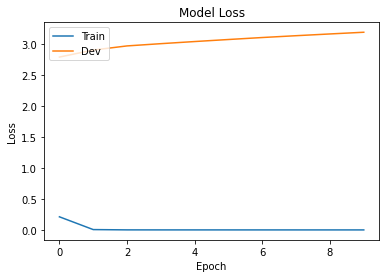

<Figure size 432x288 with 0 Axes>

In [32]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Dev'],loc ='upper left')
plt.show()
plt.savefig("TRIAL5_model_ResNet50_MULTI_RGB_SIGMOID_image224_epoch10_stepSize10.png")

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Dev'],loc ='upper left')
plt.show()
plt.savefig("TRIAL5_model_ResNet50_MULTI_RGB_SIGMOID_image224_epoch10_stepSize10.png")

In [33]:
NUM = STEP_SIZE_TEST*BATCH_SIZE

images = test_batch_X() # currently in numpy
ID = test_batch_ID()
ID = ID.reshape(ID.shape[0],1)
y_true = test_batch_Y()
y_true = np.array(y_true, dtype=int)
print(images.shape)
print(ID.shape)
print(y_true)

my_model = load_model("TRIAL5_model_ResNet50_MULTI_RGB_SIGMOID_image224_epoch10_stepSize10.h5")
pred = my_model.predict_on_batch(images)
pred_bool = (pred >= 0.5)
y_pred = np.array(pred_bool, dtype = int)
 # currently in numpy (dtype = int)

# Save the values 
prediction = np.append(ID, y_pred, axis = 1)
#prediction = np.append(prediction, y_true, axis = 1)
prediction_df=pd.DataFrame(prediction)
prediction_df.rename({0:"ID", 1: "y_pred", 2:"y_true"}, axis=1)
prediction_df.to_csv("Prediction_TRIAL5_model_ResNet50_MULTI_RGB_SIGMOID_image224_epoch10_stepSize10.csv")
prediction_df.head()

(128, 448, 448, 3)
(128, 1)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,0,1
0,ID_07c1de1a6,0
1,ID_b0acf1e55,1
2,ID_a8b33969f,0
3,ID_8abe5dfd5,0
4,ID_0026de01c,0


In [34]:
#print(y_true,y_pred)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


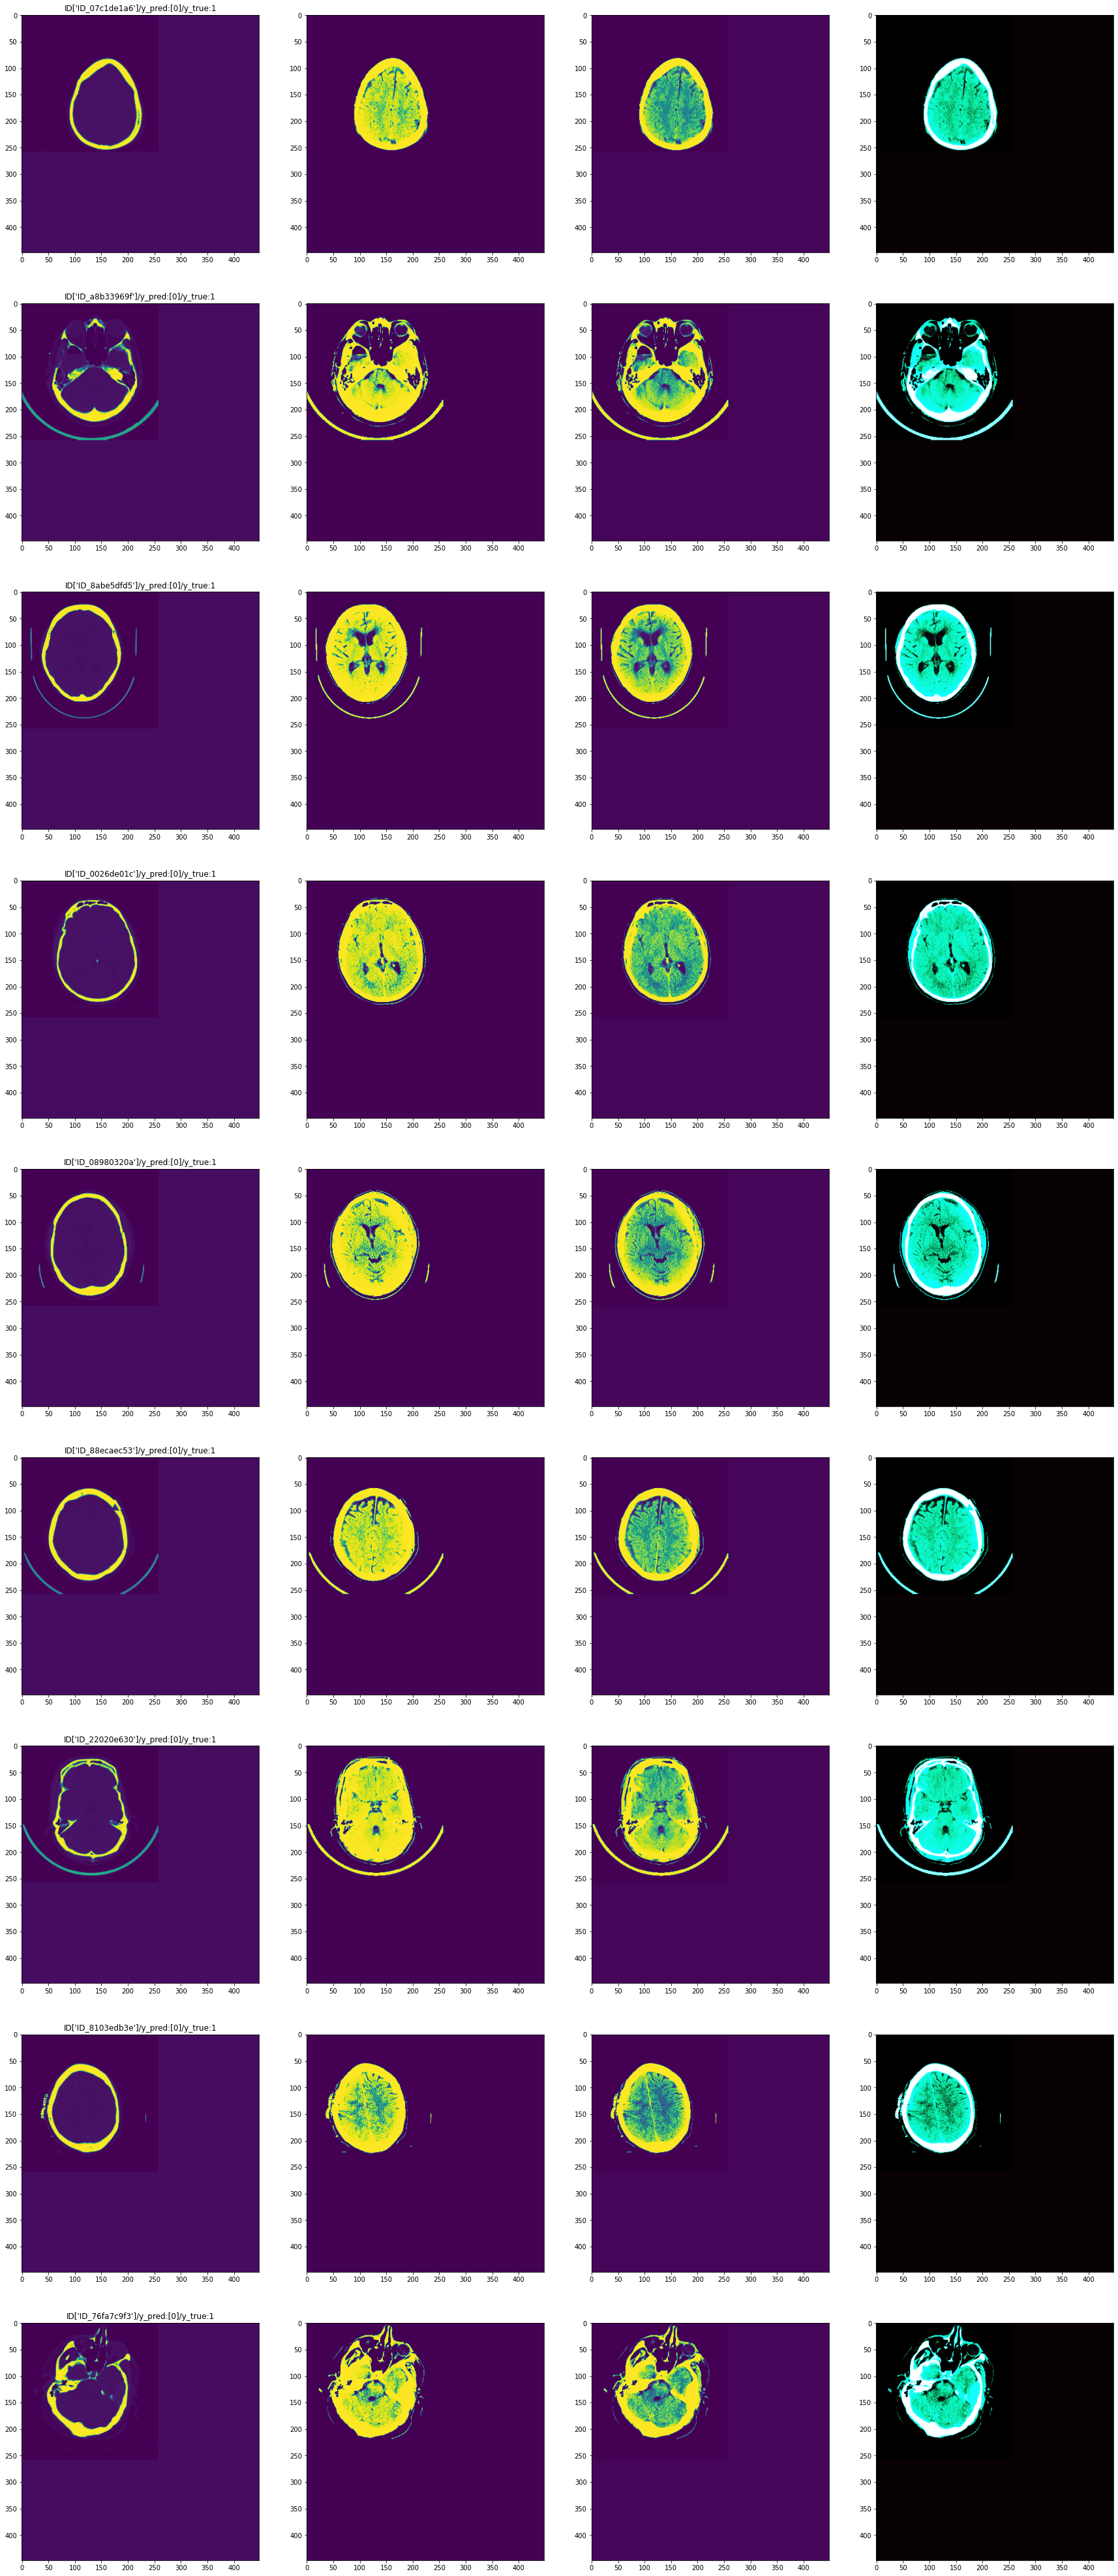

In [35]:
def display_wrong_images(path=trainingImagesDir, ID =ID, y_pred=y_pred, y_true=y_true):
    # compare 3 windows
    fig= plt.figure(figsize = (30,80))
    columns = 4 ; rows = 10
    
    num=1
    batch_size = 128
    image = np.zeros((batch_size, 448, 448, 3),dtype=int)
    for i in range(len(y_pred)):
        if (y_pred[i].any()!=y_true[i].any()) & (num < rows):
            pixel_image_temp = pydicom.dcmread(path+ID[i][0]+".dcm")
            HU_image_temp = pixel2HULL(pixel_image_temp)
            image[i,:,:,0]=set_sigmoid_window(HU_image_temp, 600, 2000) #Bone
            image[i,:,:,1]=set_sigmoid_window(HU_image_temp, 40, 80) #Brain
            image[i,:,:,2]=set_sigmoid_window(HU_image_temp, 50, 130) #Blood               
            
            ax=fig.add_subplot(rows, columns, (num-1)*columns+1)
            plt.imshow(image[i,:,:,0])#, cmap="gray", vmin = 0, vmax = 255)
            ax.set_title("ID"+str(ID[i])+"/y_pred:"+str(y_pred[i])+"/y_true:"+str(y_true[i]))
            fig.add_subplot(rows, columns, (num-1)*columns+2)
            plt.imshow(image[i,:,:,1])#, cmap="gray", vmin = 0, vmax = 255)
            fig.add_subplot(rows, columns, (num-1)*columns+3)
            plt.imshow(image[i,:,:,2])#, cmap="gray", vmin = 0, vmax = 255)
            fig.add_subplot(rows, columns, (num-1)*columns+4)
            plt.imshow(image[i])#, cmap="gray", vmin = 0, vmax = 255)            
            num=num+1       
display_wrong_images()

(128,)
(128, 1)
(128, 1)


<Figure size 432x288 with 0 Axes>

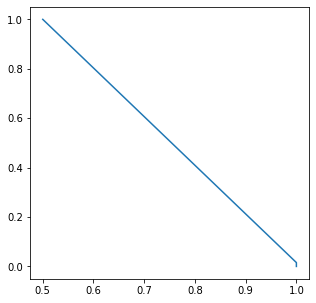

<Figure size 432x288 with 0 Axes>

In [36]:
print(y_true.shape)
print(y_pred.shape)
print(pred.shape)
fig= plt.figure(figsize = (5,5))
precision, recall, _= precision_recall_curve(y_true[:], pred[:]) 
plt.plot(precision, recall)
plt.figure()
#Compute precision-recall pairs for different probability thresholds

In [37]:
from sklearn.metrics import confusion_matrix
print("")
print ("confusion matrix")
print (confusion_matrix(y_true ,y_pred))

tp, fp, fn, tn = confusion_matrix(y_true ,y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity= tp/(tp+fn)
precision= tp/(tp+fp)
f1_score= (2*sensitivity*precision)/(sensitivity+precision)



print("precision = ",precision)
print("sensitivity = ",sensitivity)
print("specificity = ",specificity)
print("f1_score = ",f1_score)





confusion matrix
[[64  0]
 [63  1]]
precision =  1.0
sensitivity =  0.5039370078740157
specificity =  1.0
f1_score =  0.6701570680628273
